### Khai báo các thư viện cần thiết

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
# from preprocess import TextPreprocessor

2025-06-15 08:30:28.594357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749976228.618829    1082 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749976228.626180    1082 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# 1️⃣ **Tải dữ liệu**
data = pd.read_csv(r"/kaggle/input/sadsadsa/Data.csv")  # Thay bằng đường dẫn file dữ liệu của bạn

### Tiền xử lí dữ liệu cho cột Content

In [5]:
preprocessor = TextPreprocessor(r'/kaggle/input/sadsadas/stopwords3.txt')
data = preprocessor.preprocess_data(data)

In [6]:
print(data['Content'].head())

0    tập_đoàn novaland ( nvl ) vừa công_bố chậm trả...
1    trang_trại bò sữa hữu_cơ trang_trại nghệ_an tậ...
2    đồ_thị vn - index " mắc võng " mô_hình : sắc x...
3    lucas lee - tyson khai_thác sức_mạnh internet ...
4    hầu_hết thị_trường chứng_khoán châu á giao_dịc...
Name: Content, dtype: object


In [7]:
max_words = 20000
max_len = 1000

### Mã hóa

In [8]:
X_texts = data['Content'].apply(lambda x: x.split())  # Tách câu thành danh sách từ
ohe = OneHotEncoder()
y = ohe.fit_transform(data[['Label']]).toarray()  # Chuyển nhãn thành numpy array

In [9]:
print(X_texts)

0        [tập_đoàn, novaland, (, nvl, ), vừa, công_bố, ...
1        [trang_trại, bò, sữa, hữu_cơ, trang_trại, nghệ...
2        [đồ_thị, vn, -, index, ", mắc, võng, ", mô_hìn...
3        [lucas, lee, -, tyson, khai_thác, sức_mạnh, in...
4        [hầu_hết, thị_trường, chứng_khoán, châu, á, gi...
                               ...                        
28621    [nửa_đêm, ,, cảnh_sát, cuộc_gọi, trình_báo, ma...
28622    [,, marlene, warren, ,, ,, trai, tên, joseph, ...
28623    [tối, ,, tumd, youqi, ,, thành_phố, bao, ,, kh...
28624    [,, alisa, mathewson, giật, tỉnh_giấc, phòng, ...
28625    [,, tổng_đài, cảnh_sát, huyện, mông, thành, ,,...
Name: Content, Length: 28626, dtype: object


### Huấn luyện mô hình Word2Vec

In [10]:
w2v_model = Word2Vec(sentences=X_texts, vector_size=150, window=5, min_count=1, workers=4)

### Tạo từ điển ánh xạ từ → embedding

In [11]:

embedding_matrix = np.zeros((max_words, 150))
word_index = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}  # Bắt đầu từ 1 vì 0 dành cho padding

for word, i in word_index.items():
    if i < max_words:
        embedding_matrix[i] = w2v_model.wv[word]

### Mã hóa văn bản bằng Word2Vec

In [12]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.word_index = word_index  # Ánh xạ word2vec vào tokenizer

In [13]:
X = tokenizer.texts_to_sequences(X_texts)
X = pad_sequences(X, maxlen=max_len)

### Chia tập train/test 85:15

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=100)

### Xây dựng model GRU

In [15]:
from tensorflow.keras.layers import LSTM, Bidirectional, Activation
def define_model1():
    inputs = Input(shape=(max_len,))
    embedding = Embedding(input_dim=max_words, output_dim=150, weights=[embedding_matrix], trainable=False)(inputs)

    layer = GRU(128, return_sequences=True)(embedding)
    layer = GRU(64, return_sequences=True)(layer)
    layer = GRU(32, return_sequences=False)(layer)

    layer = Dense(128)(layer)
    layer = BatchNormalization()(layer)  # Đặt BatchNorm trước activation
    layer = Activation('relu')(layer)  # Hàm kích hoạt
    layer = Dropout(0.5)(layer)

    layer = Dense(64)(layer)
    layer = BatchNormalization()(layer)  # Đặt BatchNorm trước activation
    layer = Activation('relu')(layer)  # Hàm kích hoạt
    layer = Dropout(0.3)(layer)

    layer = Dense(32)(layer)
    layer = BatchNormalization()(layer)  # Đặt BatchNorm trước activation
    layer = Activation('relu')(layer)  # Hàm kích hoạt
    layer = Dropout(0.1)(layer)

    layer = Dense(13, activation='softmax')(layer)  # Lớp đầu ra

    model1 = Model(inputs=inputs, outputs=layer)
    model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

    return model1

model1 = define_model1()

I0000 00:00:1749976746.897468    1082 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749976746.898083    1082 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1000, 150)           │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 1000, 128)           │         107,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 1000, 64)            │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │             429 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,170,061 (12.09 MB)

 Trainable params: 169,613 (662.55 KB)

 Non-trainable params: 3,000,448 (11.45 MB)

### Huấn luyện model GRU

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath="Gru_model.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

history = model1.fit(
    X_train, y_train,
    batch_size=32,
    epochs=40,
    validation_split=0.11,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/40


I0000 00:00:1749976756.078049    1154 cuda_dnn.cc:529] Loaded cuDNN version 90300


677/677 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1171 - loss: 2.6730
Epoch 1: val_loss improved from inf to 2.07199, saving model to Gru_model.keras
677/677 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.1172 - loss: 2.6728 - val_accuracy: 0.3687 - val_loss: 2.0720
Epoch 2/40
677/677 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2836 - loss: 2.1787
Epoch 2: val_loss improved from 2.07199 to 1.78314, saving model to Gru_model.keras
677/677 ━━━━━━━━━━━━━━━━━━━━ 61s 90ms/step - accuracy: 0.2836 - loss: 2.1786 - val_accuracy: 0.4767 - val_loss: 1.7831
Epoch 3/40
677/677 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3964 - loss: 1.9121
Epoch 3: val_loss improved from 1.78314 to 1.49631, saving model to Gru_model.keras
677/677 ━━━━━━━━━━━━━━━━━━━━ 61s 91ms/step - accuracy: 0.3964 - loss: 1.9120 - val_accuracy: 0.5850 - val_loss: 1.4963
Epoch 4/40
677/677 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5158 - loss: 1.6016
Epoch 4: val_loss improved from 1.49631 to 1.16582, saving

### Tính toán các độ đo 

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load mô hình đã lưu từ file H5
model1 = load_model("/kaggle/working/Gru_model.keras")
print("✅ Mô hình đã được load thành công từ best_model.keras")

# Dự đoán trên tập kiểm tra
y_preds = model1.predict(X_test)
y_preds = np.argmax(y_preds, axis=1)  # Chuyển dự đoán thành nhãn

# Nếu y_test là one-hot vector, chuyển về dạng index
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# Tính các độ đo đánh giá
accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='macro')
recall= recall_score(y_test, y_preds, average='macro')
f1 = f1_score(y_test, y_preds, average='macro')

# In kết quả
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-score: {f1:.4f}")

✅ Mô hình đã được load thành công từ best_model.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
✅ Accuracy: 0.9036
✅ Precision: 0.9074
✅ Recall: 0.9061
✅ F1-score: 0.9062


### Ma trận nhầm lẫn

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def confusionMatrix(y_actual, pred):
    confusion_matrix(y_actual, pred)

    cm = confusion_matrix(y_actual, pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    tick_marks = np.arange(13)
    plt.xticks(tick_marks, ohe.categories_[0], rotation=90)  # Lấy danh sách các nhãn
    plt.yticks(tick_marks, ohe.categories_[0], rotation=0)

    thresh = cm.max() / 10.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

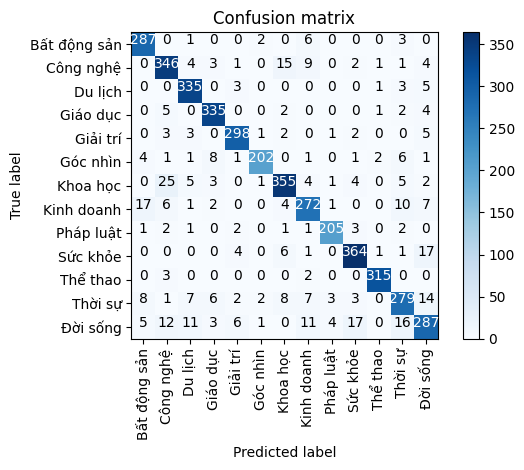

In [20]:
confusionMatrix(y_test, y_preds)